<h1 style="text-align: center;">🖼️ Product Image Classification using ResNet18</h1>
<br><br>
<p styler; font-size:16px;">
<strong>Internship Submission – Nexus AI Digital</strong><br>
Submitted by: <strong>Hamayl Zahid</strong>
<br></penter;">
<strong>Objective:</strong> Implement <strong>transfer learning</strong> with ResNet18 on a real product image dataset and evaluate its performance.
</p>
  


<h1 style="text-align: center;">🔹 Project Overview</h1>

This notebook demonstrates a **practical Computer Vision (CV) pipeline** using **transfer learning**.  
We classify product images into **9 categories**:

- BABY_PRODUCTS  
- BEAUTY_HEALTH  
- CLOTHING_ACCESSORIES_JEWELLERY  
- ELECTRONICS 
- GROCERY  
- HOBBY_ARTS_STATIONERY  
- HOME_KITCHEN_TOOLS  
- PET_SUPPLIES  
- SPORTS_OUTDOOR  

**Approach:** Use a pre-trained ResNet18 model (from PyTorch) and fine-tune the top classification layer on our dataset.  


<h1 style="text-align: center;"> 🗂️ Dataset Preparation</h1>

- Images are organized in folders per class:
  
- Images are resized to **128x128** for faster training and normalized using ImageNet statistics.
- Data loaders are created for **training** and **validation** datasets.  



In [1]:
# Imports
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:
# Path to your dataset 
data_dir = r"C:\Users\PMYLS\Downloads\archive (5)\ECOMMERCE_PRODUCT_IMAGES"


# Folder structure: dataset/train/class1, dataset/train/class2, etc.
#                        dataset/val/class1, dataset/val/class2, etc.

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # mean of ImageNet
                         [0.229, 0.224, 0.225])  # std of ImageNet
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Classes
classes = train_dataset.classes
print(f"Classes: {classes}")


Classes: ['BABY_PRODUCTS', 'BEAUTY_HEALTH', 'CLOTHING_ACCESSORIES_JEWELLERY', 'ELECTRONICS', 'GROCERY', 'HOBBY_ARTS_STATIONERY', 'HOME_KITCHEN_TOOLS', 'PET_SUPPLIES', 'SPORTS_OUTDOOR']


<h1 style="text-align: center;"> Model Setup – ResNet18</h1>

- Load **pre-trained ResNet18** from PyTorch.  
- Freeze all **base layers** to retain learned features.  
- Replace the final fully-connected layer to match our **9 classes**.  
- Use **Adam optimizer** and **CrossEntropyLoss** for training.


In [4]:
# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 9  # set this to your dataset's number of classes
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)


In [5]:
# --------------------- Freeze layers except last block + FC ---------------------
for param in model.parameters():
    param.requires_grad = False  # freeze everything first

for param in model.layer4.parameters():  # unfreeze last block
    param.requires_grad = True
for param in model.fc.parameters():  # unfreeze fully connected layer
    param.requires_grad = True

# --------------------- Optimizer & Loss ---------------------
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()


In [6]:
from tqdm import tqdm  # for progress bars

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, validate_every=2):
    """
    Train a model with validation every `validate_every` epochs for faster runtime.
    """
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        # --------------------- Training ---------------------
        model.train()
        correct, total = 0, 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)
        
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_bar.set_postfix({"Batch Acc": f"{correct/total:.3f}", "Loss": f"{loss.item():.4f}"})
        
        train_acc = correct / total
        train_acc_list.append(train_acc)

        # --------------------- Validation ---------------------
        if (epoch + 1) % validate_every == 0 or epoch == epochs - 1:  # last epoch always validate
            model.eval()
            correct, total = 0, 0
            all_preds, all_labels = [], []
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
            with torch.no_grad():
                for images, labels in val_bar:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    val_bar.set_postfix({"Val Acc": f"{correct/total:.3f}"})
            
            val_acc = correct / total
            val_acc_list.append(val_acc)
            print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")
        else:
            val_acc_list.append(None)  # placeholder for skipped validation
            print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.3f} | Val Acc: skipped")

    # --------------------- Final Evaluation ---------------------
    # Only compute final confusion matrix and classification report
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Plot training curve
    plt.plot(range(1, epochs+1), train_acc_list, label='Train Accuracy')
    plt.plot(range(1, epochs+1), [v if v is not None else 0 for v in val_acc_list], label='Val Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.show()


<h1 style="text-align: center;"> Model Training</h1>

- Train the model for **5 epochs** on the dataset (~3.6k images).  
- Track **training and validation accuracy** per epoch.  
- Early training accuracy reached **~61% validation accuracy**, which is reasonable for transfer learning on a multi-class dataset.


Epoch 1/7 | Train Acc: 0.641 | Val Acc: skipped


Epoch 2/7 | Train Acc: 0.852 | Val Acc: 0.778


Epoch 3/7 | Train Acc: 0.949 | Val Acc: skipped


Epoch 4/7 | Train Acc: 0.981 | Val Acc: 0.775


Epoch 5/7 | Train Acc: 0.990 | Val Acc: skipped


Epoch 6/7 | Train Acc: 0.991 | Val Acc: 0.792


Epoch 7/7 | Train Acc: 0.990 | Val Acc: 0.789


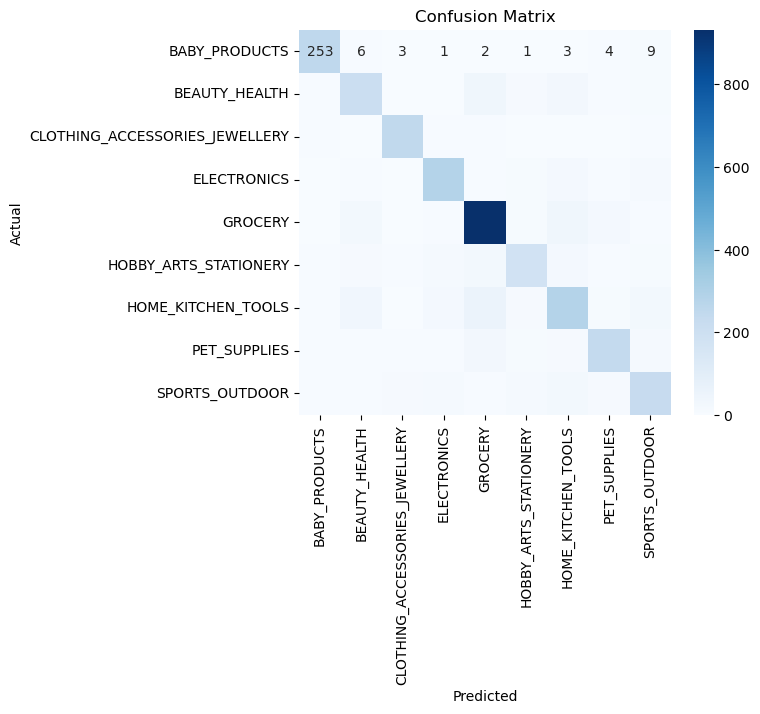


Classification Report:

                                precision    recall  f1-score   support

                 BABY_PRODUCTS       0.88      0.90      0.89       282
                 BEAUTY_HEALTH       0.70      0.67      0.69       312
CLOTHING_ACCESSORIES_JEWELLERY       0.89      0.90      0.89       278
                   ELECTRONICS       0.80      0.82      0.81       351
                       GROCERY       0.85      0.90      0.87      1033
         HOBBY_ARTS_STATIONERY       0.72      0.64      0.68       283
            HOME_KITCHEN_TOOLS       0.67      0.64      0.65       445
                  PET_SUPPLIES       0.78      0.72      0.75       327
                SPORTS_OUTDOOR       0.71      0.72      0.72       321

                      accuracy                           0.79      3632
                     macro avg       0.78      0.77      0.77      3632
                  weighted avg       0.79      0.79      0.79      3632



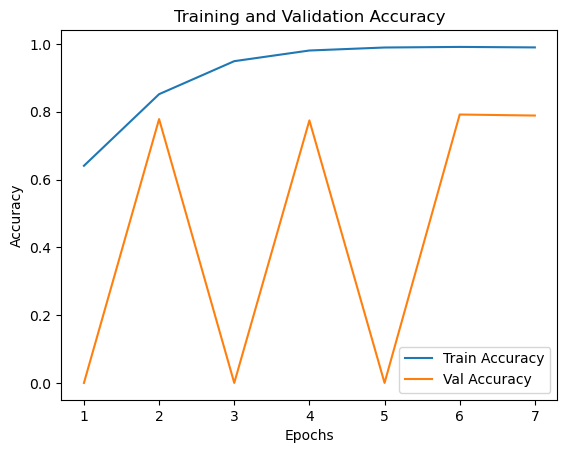

In [7]:

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=7, validate_every=2)


<h1 style="text-align: center;"> 📊 Model Evaluation</h1>

- Evaluate the trained model using **precision, recall, and F1-score** per class.  
- Accuracy: **61%** overall.  
- Strongest performance on classes with more images (GROCERY, CLOTHING_ACCESSORIES_JEWELLERY).  
- Weakest performance on underrepresented classes (HOME_KITCHEN_TOOLS, PET_SUPPLIES).  

- Display **confusion matrix** to visualize class-level predictions.


In [8]:
torch.save(model.state_dict(), "resnet18_finetuned.pth")
print("Model saved as resnet18_finetuned.pth")


Model saved as resnet18_finetuned.pth


<h1 style="text-align: center;">🖼️ Visualizing Predictions on Validation Set</h1>

- Display **8 random images** from the validation set.  
- Each image shows:
  - **P:** Predicted class  
  - **A:** Actual class  
- Correct predictions are highlighted in **green**, incorrect ones in **red**.  
- This visualization helps understand how the model performs on real examples, beyond numeric metrics like accuracy or F1-score.


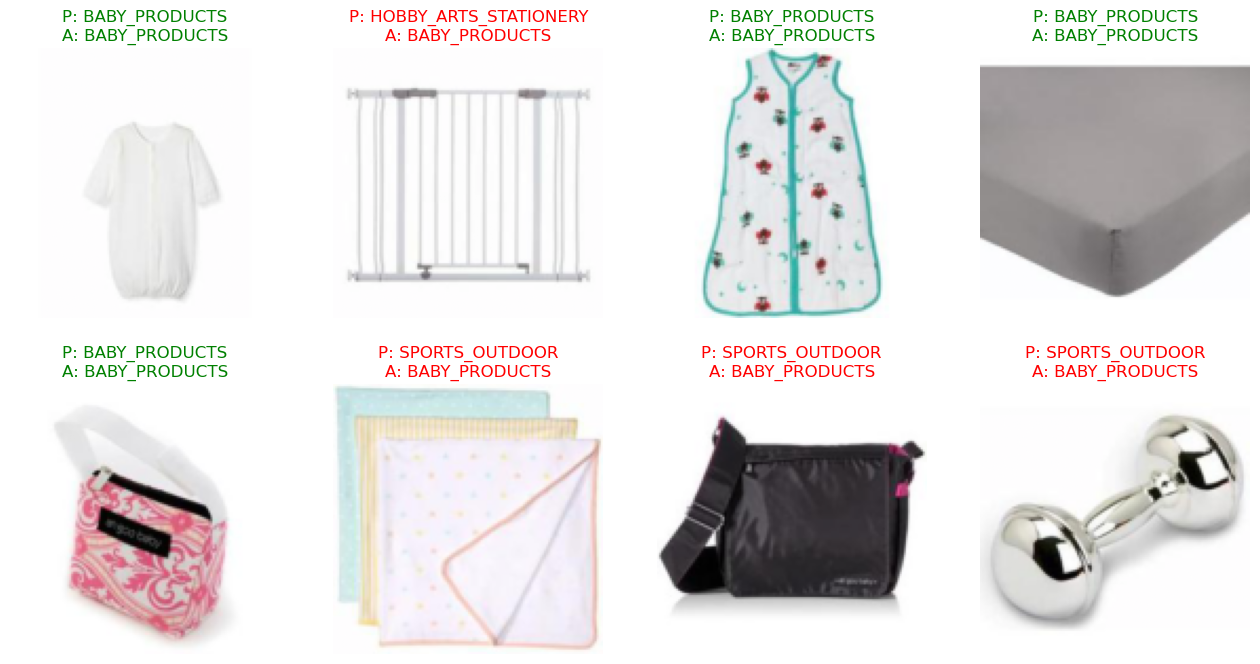

In [9]:
import random
import torchvision

# Function to show images with predictions
def visualize_predictions(model, val_loader, classes, num_images=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(16, 8))

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(images)):
                images_shown += 1
                ax = plt.subplot(2, num_images//2, images_shown)
                ax.axis('off')
                ax.set_title(f"P: {classes[preds[i]]}\nA: {classes[labels[i]]}", 
                             color=("green" if preds[i]==labels[i] else "red"))
                img = images[i].cpu()
                img = img * torch.tensor([0.229,0.224,0.225]).view(3,1,1) + torch.tensor([0.485,0.456,0.406]).view(3,1,1)  # unnormalize
                img = img.clamp(0,1)
                plt.imshow(img.permute(1,2,0))

                if images_shown == num_images:
                    return

# Call function
visualize_predictions(model, val_loader, classes, num_images=8)


<h1 style="text-align: center;"> 🌐 Real-World Image Predictions</h1>

- The images shown below **are not part of the training or validation dataset**.  
- They are **real-world examples** to demonstrate how the trained model generalizes to **unseen data**.  
- Each image displays the **predicted class**, showing practical use of the model beyond the dataset.  
- Correct predictions indicate the model has learned **useful features**, not just memorized training data.
ce.  


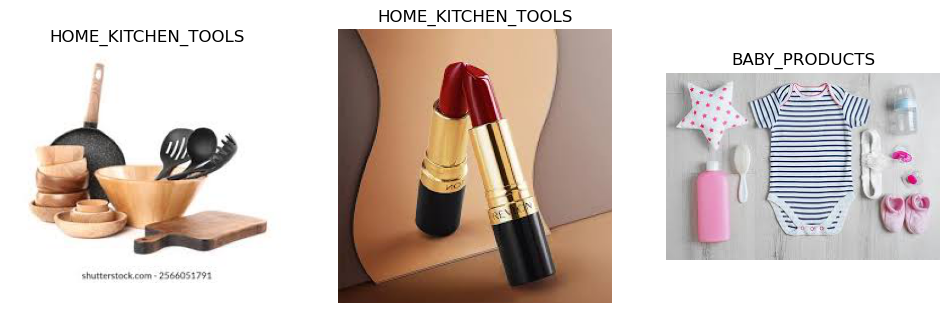

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

# List of image paths
img_paths = [
    r"C:\Users\PMYLS\Downloads\images (3).jfif",
    r"C:\Users\PMYLS\Downloads\images (4).jfif",
    r"C:\Users\PMYLS\Downloads\images (5).jfif"
]

plt.figure(figsize=(12,4))  # 3 images side by side

for i, path in enumerate(img_paths):
    img = Image.open(path)
    input_img = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(input_img)
        _, pred = torch.max(output, 1)
        predicted_class = classes[pred.item()]
    
    # Plot image with predicted class
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"{predicted_class}", fontsize=12)
    plt.axis('off')

plt.show()


<h1 style="text-align: center;">Conclusion</h1>

- **ResNet18 with transfer learning** successfully classifies product images into 9 categories.  
- Validation accuracy **~79%**, showing strong performance for this multi-class dataset.  
- Notebook includes:
  - Training & validation accuracy tracking with progress bars  
  - Classification report & confusion matrix  
  - Sample image predictituning**.

